# EMERGE: Constraining observation timescales of merging galaxies
##### About:
This notebook is intended to provide the scripts necessary to reproduce the key results shown [here](https://ui.adsabs.harvard.edu/abs/2020arXiv200102687O/abstract). I omit plots that include data and results of other works.

##### Data:
The data necessary to reproduce these results can be found [here](http://www.usm.uni-muenchen.de/emerge/data/galtrees/hdf5/). This data is produced using the code [EMERGE](http://www.usm.uni-muenchen.de/emerge/)

##### Code:
To run this notebook you will also need to install my personal library of analysis tools [galaxybox](https://github.com/jaoleary/galaxybox). If there are questions regarding the usage of these tools please consult that repository directly...or contact me.

##### Discalimer:
This notebook relies on publicly available data and codes, I cannot gurantee that updates to either of this won't result in a change to the results shown in this notebook or the associated paper. If for some reason you are unable to run this notebook or if you find some error **please** contact me.

# RUN THESE CELLS FIRST

## IMPORT LIBRARIES

In [11]:
from galaxybox_dev import sim_managers as gb

# plotting
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import matplotlib.patheffects as PathEffects
import matplotlib.patches as patches
from matplotlib import container
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#astropy
from astropy import cosmology as apcos
import astropy.units as apunits

# scipy
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic
import scipy.interpolate as interpolate
import scipy.integrate as integrate

# other
import os
import pandas as pd
import numpy as np
from multiprocessing import Pool
from jupyterthemes import jtplot # This is not a necessary library. But im a sucker for dark themes
from tqdm.auto import tqdm
import h5py
import warnings
warnings.filterwarnings("ignore")

## PLOTTING DEFAULTS

In [2]:
jtplot.reset()
plt.rcParams.update({'axes.linewidth' : 2,
                     'xtick.labelsize' : 16,
                     'xtick.major.width' : 2,
                     'xtick.major.size'  : 6,
                     'xtick.minor.width'  : 1,
                     'xtick.minor.size'  : 3,
                     'xtick.top' : True,
                     'xtick.direction' : 'in',
                     'ytick.labelsize' : 16,
                     'ytick.major.width' : 2,
                     'ytick.major.size'  : 6,
                     'ytick.minor.width'  : 1,
                     'ytick.minor.size'  : 3,
                     'ytick.right' : True,
                     'ytick.direction' : 'in',
                     'font.family':'serif',
                     'mathtext.fontset': 'cm'})

## IMPORT DATA

In [3]:
P200 = gb.Universe(param_path = '../../Programs/emerge-dev/parameterfiles/P100.param', sim_type = 'emerge', include=['trees', 'survey'])

In [4]:
# construct some new lightcone catalogs
#P200.galaxy.survey.new_observation(group='GOODS-S', name='wide', m=8, n=5, min_z=0.5, max_z=3, min_mstar=9, fuzzy_bounds=True, randomize=True, seed=42)
#P200.galaxy.survey.new_observation(group='GOODS-N', name='wide', m=8, n=5, min_z=0.5, max_z=3, min_mstar=9, fuzzy_bounds=True, randomize=True, seed=24)
#P200.galaxy.survey.save()

# load previously saved lightcone catalogs
P200.galaxy.survey.load_group(group='GOODS-S', link_trees=True)
P200.galaxy.survey.load_group(group='GOODS-N', link_trees=True)

# Compute pair fractions

In [5]:
# first bin then setup the distance matrix for each observation
observations = [('GOODS-S', 'wide'),
                ('GOODS-N', 'wide')]
for i, obs in enumerate(observations):
    group, name = obs
    P200.galaxy.survey.obs(group=group, name=name).set_cone_slice(bins=5)
    P200.galaxy.survey.obs(group=group, name=name).set_distance_matrix(max_distance=0.1, comoving=False)


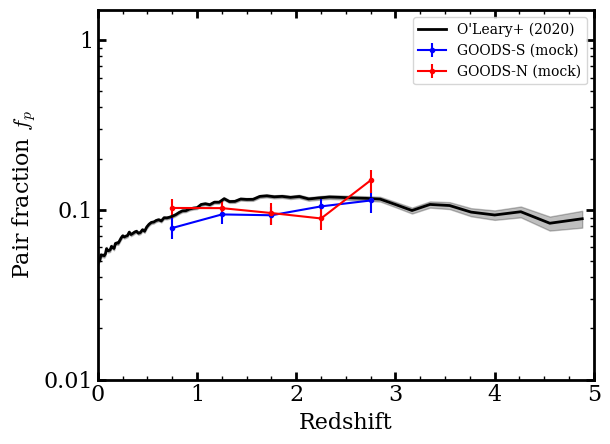

In [21]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_xlim(0,5)
ax.set_ylim(0.01, 1.5)
ax.set_ylabel('Pair fraction $f_{p}$', size=16)
ax.set_xlabel('Redshift', size=16)
ax.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(0.25, 4.5+75, 0.25)))

color = ['b','r']

pairs = pd.read_hdf('./pair_counts.h5', key='P4')

z=pairs['redshift']
Np = (pairs['rp:50']-pairs['rp:5'])
Ng = pairs['N_gal']
fp = Np/Ng
err = fp/np.sqrt(Np)
ax.plot(z, fp,color='k', lw=2,label='O\'Leary+ (2020)')
ax.fill_between(z,fp+err,fp-err,alpha=0.25, color='k')

for i, obs in enumerate(observations):
    group, name = obs
    bins = P200.galaxy.survey.obs(group=group, name=name).redshift_bins
    z = (bins[:-1] + bins[1:])/2
    pairs = P200.galaxy.survey.obs(group=group, name=name).get_pairs(r_min=0.005, r_max=0.05, min_mstar=10.3)
    Np = np.array([len(p) for p in pairs])
    Ng = np.array([len(P200.galaxy.survey.obs(group=group, name=name).list(slice=[i], min_mstar=10.3)) for i in range(len(Np))])
    fp = Np/Ng
    err = fp/np.sqrt(Np)
    ax.errorbar(z, fp, yerr=err, marker='.', color=color[i],label=group+' (mock)')
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))

    plt.legend()
plt.show()

## Compute correction factor

## Compute observation timescales

# SCRATCH

In [24]:
P200.galaxy.trees.head()

,Scale,Up_ID,Desc_ID,Main_ID,MMP_ID,Coprog_ID,Leaf_ID,Original_ID,Num_prog,MMP,...,X_pos,Y_pos,Z_pos,X_vel,Y_vel,Z_vel,tdf,Age,Type,Flag
ID,,,,,,,,,,,,,,,,,,,,,
143,1.00,11905,0,11905,144,0,229,13870185,1,1,...,1.001557,10.257502,23.660570,122.000000,-160.729996,-232.169998,763.614929,13.799319,2,0
144,0.99,11906,143,11906,145,0,229,13870184,1,1,...,0.989272,10.283062,23.695049,135.899994,-145.080002,-267.619995,763.614929,13.654740,2,0
145,0.98,11907,144,11907,146,0,229,13870183,1,1,...,0.968066,10.301411,23.743420,134.380005,-142.279999,-270.619995,763.614929,13.509388,2,0
146,0.97,11908,145,146,147,0,229,13304730,1,1,...,0.774576,10.098363,24.075182,-120.019997,518.109985,237.589996,13.363264,13.363264,1,0
147,0.96,11909,146,147,148,0,229,13166735,1,1,...,0.792980,10.036529,24.035158,-107.800003,350.399994,276.730011,13.216373,13.216373,1,0
